# Representation of biomedical knowledge in transformer-based deep neural networks

### Introduction

Biomedical knowledge is important for understanding of human diseases, enabling precise and timely diagnostics and development of effective treatments for various conditions. However, even though some part of biomedical knowledge is available in the form of structured, machine-readable databases, the major part remains represented as unstructured text, i.e. as a publications in research journals and books. PubMed, the largest index of biomedical literature, includes more than 37 million citations to date. Recent advances in natural language processing made possible large-scale, automatic extraction, analysis and synthesis of that knowledge, further advancing our understanding of the inner workings of human body.

One of the earliest successfull experiments was data mining over 70,000 research abstracts performed on IBM Watson supercomputer in 2014, leading to automated discovery of new protein kinases for TP53 [1]. TP53 is a tumour suppressor gene that is often damaged or missing in cancer patients, along with other genes, such as EGFR or KRAS, where mutations drive tumour growth and progression of the disease. These genes comprise the class of *cancer-driver genes*.

Methods for identification of cancer-driver genetic mutations is an active area of research [2]. Identifying mutations involved in cancer enables development of targeted and even personalized therapies, that have come to play an increasingly important role over the past two decades [3]. Unlike chemotherapy or radiotherapy, that affect both healthy and malignant cells, targeted therapies act in a more precise way, producing rapid tumour regression without inflicting toxic damage to healthy tissues.

This work will study application of transformer neural networks (BERT, Megatron, LLaMA and GPT) trained on biomedical literature to the tasks of cancer driver gene identification and treatment outcome prediction (e.g. whether patient with cancer will respond to treatment with a drug designed to target specific genetic mutation).

### Importing libraries

In [57]:
import os
import re
import math
import json
import torch
import numpy
import pandas
import string
import random
import datasets
import statistics
import transformers

from datasets import Dataset, DatasetDict
from statistics import mean, median
from tabulate import tabulate
from tqdm.notebook import tqdm

from matplotlib import pyplot, colors
from matplotlib.patches import FancyBboxPatch

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from transformers import BioGptTokenizer, BioGptForCausalLM, BioGptForSequenceClassification
from transformers import BitsAndBytesConfig, pipeline, set_seed
from transformers.trainer_callback import PrinterCallback

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

os.environ["TOKENIZERS_PARALLELISM"] = "false"

transformers.logging.set_verbosity_error()
transformers.utils.logging.disable_progress_bar()
datasets.utils.logging.disable_progress_bar()
tqdm.pandas()

### Task 1. Identification of cancer driver genes

Tumour cells typically carry a lot of mutations, but only mutations in some genes are important in developing cancer. These are primarily genes that are involved in cell division process, either encouraging cell to multiply (oncogenes) or blocking further multiplication (tumour suppressor genes).

In 2004, a list of 291 cancer genes was compiled based on manual analysis of published literature: only those mutations that are highly unlikely to be due to chance were included [4].

More recently, different computational tools have been developed that attempt to identify driver genes based on large-scale analysis of patient tumour samples, biological and chemical properties of amino acids, networks of interactions and so on; many approaches rely on machine learning algorithms, such as SVM or random forests [5].

COSMIC Cancer Gene Census is an expert-curated dataset that currently includes 728 genes driving human cancer [6]. The list is not exhaustive, as it comprises only those genes that have enough evidence support to date. Therefore, computational tools can identify a larger number of potential drivers: for example, analysis of 8000+ tumour samples performed by Moonlight revealed 1000+ cancer driver genes [7].

Computational language modeling have been so far successfully applied to discover previously unknown entities that have specific properties, such as *thermoelectric* materials or *p53-phosphorylating* protein kinases [1,8], because they tend to cluster with already-known entities based on similar embeddings. Potentially, cancer driver genes can also be discovered with the same method.

#### Dataset preparation

The dataset of known cancer-driver genes was manually dowloaded from COSMIC website (cancer.sanger.ac.uk/cosmic/download/cosmic/v101/cancergenecensus) as it is available registration-only. The data is provided in .tsv format:

In [6]:
cosmic = pandas.read_csv('dataset/Cosmic_CancerGeneCensus_v101_GRCh38.tsv', sep = '\t')
cosmic

,GENE_SYMBOL,NAME,COSMIC_GENE_ID,CHROMOSOME,GENOME_START,GENOME_STOP,CHR_BAND,SOMATIC,GERMLINE,TUMOUR_TYPES_SOMATIC,...,CANCER_SYNDROME,TISSUE_TYPE,MOLECULAR_GENETICS,ROLE_IN_CANCER,MUTATION_TYPES,TRANSLOCATION_PARTNER,OTHER_GERMLINE_MUT,OTHER_SYNDROME,TIER,SYNONYMS
0,A1CF,APOBEC1 complementation factor,COSG68236,10,50799409.0,50885675.0,10q11.23,y,n,melanoma,...,NaN,E,NaN,oncogene,Mis,NaN,n,NaN,2,"A1CF,ENSG00000148584.14,29974,ACF,ACF64,ACF65,..."
1,ABI1,abl interactor 1,COSG100962,10,26746593.0,26861087.0,10p12.1,y,n,AML,...,NaN,L,Dom,"TSG, fusion",T,KMT2A,n,NaN,1,"ABI1,ENSG00000136754.17,Q8IZP0,10006,ABI-1,E3B1"
2,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",COSG106650,9,130713946.0,130887675.0,9q34.12,y,n,"CML, ALL, T-ALL",...,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",n,NaN,1,"ABL1,ENSG00000097007.17,P00519,25,JTK7,c-ABL,p150"
3,ABL2,"ABL proto-oncogene 2, non-receptor tyrosine ki...",COSG93778,1,179099327.0,179229684.0,1q25.2,y,n,AML,...,NaN,L,Dom,"oncogene, fusion",T,ETV6,n,NaN,1,"ABL2,ENSG00000143322.19,P42684,27,ARG"
4,ACKR3,atypical chemokine receptor 3,COSG97311,2,236567787.0,236582358.0,2q37.3,y,n,lipoma,...,NaN,M,Dom,"oncogene, fusion",T,HMGA2,n,NaN,1,"ACKR3,ENSG00000144476.5,P25106,57007,GPR159,RDC1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,ZNF429,zinc finger protein 429,COSG92428,19,21496682.0,21556270.0,19p12,y,n,GBM,...,NaN,O,NaN,NaN,Mis,NaN,n,NaN,2,"ZNF429,ENSG00000197013.9,Q86V71,353088"
749,ZNF479,zinc finger protein 479,COSG111702,7,57119614.0,57139864.0,7p11.2,y,n,"lung cancer, bladder carcinoma, prostate carci...",...,NaN,E,NaN,NaN,Mis,NaN,n,NaN,2,"ZNF479,ENSG00000185177.12,Q96JC4,90827,KR19"
750,ZNF521,zinc finger protein 521,COSG65491,18,25061926.0,25352190.0,18q11.2,y,n,ALL,...,NaN,L,Dom,"oncogene, fusion",T,PAX5,n,NaN,1,"ZNF521,ENSG00000198795.10,Q96K83,25925,EHZF,Evi3"
751,ZNRF3,zinc and ring finger 3,COSG102839,22,28883592.0,29057487.0,22q12.1,y,n,"colorectal cancer, adrenocortical carcinoma, g...",...,NaN,E,NaN,TSG,"N, F, Mis",NaN,n,NaN,2,"ZNRF3,ENSG00000183579.15,Q9ULT6,84133,BK747E2...."


I will use gene symbol as an input to neural network, that will work as a classifier and output 1 if the gene is cancer related and 0 otherwise, so I will extract gene names and save them to separate list:

In [4]:
genes_cancer = set(cosmic['GENE_SYMBOL'].to_list())

open('dataset/genes_cancer.txt', 'w').write('\n'.join(genes_cancer))
print('Cancer-driver genes in COSMIC dataset: ' + ', '.join(genes_cancer) + '.')

Cancer-driver genes in COSMIC dataset: CIC, HLF, VTI1A, TFG, CYSLTR2, STIL, EWSR1, SGK1, PLAG1, KDM6A, NSD2, PAX5, USP44, ERG, ABL2, MYB, EPS15, MTOR, PLCG1, NACA, AFF4, PIK3CB, PSIP1, RBM15, KMT2A, LMO2, SDHC, BCOR, HGF, CDH1, MAML2, PHOX2B, CD74, SDC4, TMSB4X, IDH2, IRF4, BCORL1, SFPQ, MAP3K1, CCND1, CD28, PRDM1, DDR2, RAD51C, EXT1, ARHGEF10L, BRD4, FBLN2, ATF1, BCL11B, DNM2, FAS, KLF6, HOXA9, AFF1, FOXL2, KCNJ5, ZNF331, EIF3E, BCL10, BCL9L, BAZ1A, EZR, GMPS, SDHA, TMEM127, NKX2-1, B2M, LRP1B, IL2, POU2AF1, MAX, FIP1L1, IKBKB, ATR, EIF4A2, PTPN13, GPC5, HOOK3, SEPT5, NCKIPSD, TSC1, LMO1, RUNX1T1, SS18L1, BTK, KIF5B, MN1, NAB2, TSHR, CTCF, CASP9, ZBTB16, ATP1A1, SDHD, POLR2A, ECT2L, KIT, RALGDS, PDGFRB, P2RY8, FSTL3, FCGR2B, XPC, AXIN2, NUTM2D, WT1, MYOD1, FOXP1, IGH, ZRSR2, DAXX, SKI, MAPK1, MECOM, ERBB4, HOXA13, BCLAF1, NR4A3, PRKACA, TAF15, TPM3, SUFU, CCR7, MSI2, PTPRT, SIX1, CCNB1IP1, SLC45A3, ABL1, DNMT3A, FANCF, PRDM16, RGPD3, MYD88, LATS1, ALDH2, CDX2, USP8, MAP2K1, MAP2K4, IG

All genes in the list are positive samples. To train neural network, we will also need negative samples (e.g. genes that are not drivers for cancer). I will do two rounds of training: in the first round, language model will be requested to discriminate between a cancer-driver gene and a similarly-looking randomly generated sequence. In the second round, the task will be to classify between cancer drivers and other genes that are not known to be related to cancer.

To generate a sequence of symbols that is similar to gene name:

In [7]:
def lestat(sequences):
    lengths = [len(g) for g in sequences]
    me, md, ma, mi = [mean(lengths), median(lengths), max(lengths), min(lengths)]
    return f'sequence length: average {me}, median {md}, min {mi}, max {ma}'

'Gene ' + lestat(genes_cancer)

'Gene sequence length: average 4.824701195219124, median 5, min 2, max 9'

In [8]:
def chargen(size, chars = string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

def gengen():
    gen = chargen(random.randint(2,6), string.ascii_uppercase)
    if random.randint(0,1) == 1:
        gen += chargen(1, string.digits)
    if random.randint(0,4) == 4:
        gen += chargen(random.randint(1,2))
    return gen

genes_random = [gengen() for i in range(0, len(genes_cancer))]

print('Random ' + lestat(genes_random) + '\n')
print('Generated genes: ' + ', '.join(random.sample(genes_random, k = 32)) + '...')

open('dataset/genes_random.txt', 'w').write('\n'.join(genes_random)) ;

Random sequence length: average 4.873837981407703, median 5, min 2, max 9

Generated genes: LADY98, XCWM, QQFELY1, VR6, HPHRLC18, PNCYCJ6, XN, LPP, UOG2ZR, UOPBLU7, YWCDOX7, DEYBV5, CVKWQ4, LTVEKA, TCRZAY, KY, EH3, AO, EPFCXP1, WM4, TBBZMW6, PPFBL, CCWJ5, GS, OMKIRP, TXS1, AFISQ, PTUA43E, VTO7, WNX9, GHTM5, EFAGKR8...


For the second classification task, assuming that subset of cancer-driver genes should be significantly smaller than set of all genes studied in relation to various diseases, a random subset of the latter can be safely selected as negative training samples. I will use Diseases database [9] that contains information on genes related to various diseases. The database was collected automatically by text-mining of Pubmed abstracts and full-texts when article was available open access, and can be downloaded as file in .tsv format (https://download.jensenlab.org/human_disease_textmining_full.tsv)

In [9]:
diseases = pandas.read_csv('dataset/human_disease_textmining_full.tsv',
                           
                           sep    = '\t',
                           header = None,
                           names   = ['gene_ID',
                                      'gene_name',
                                      'disease_ID',
                                      'disease_name',
                                      'z',
                                      'confidence',
                                      'url']
                          )
diseases

,gene_ID,gene_name,disease_ID,disease_name,z,confidence,url
0,18S_rRNA,18S_rRNA,DOID:9643,Babesiosis,7.224,3.612,https://diseases.jensenlab.org/Entity?document...
1,18S_rRNA,18S_rRNA,DOID:1398,Parasitic infectious disease,7.013,3.506,https://diseases.jensenlab.org/Entity?document...
2,18S_rRNA,18S_rRNA,DOID:2789,Parasitic protozoa infectious disease,7.000,3.500,https://diseases.jensenlab.org/Entity?document...
3,18S_rRNA,18S_rRNA,DOID:4,Disease,6.813,3.407,https://diseases.jensenlab.org/Entity?document...
4,18S_rRNA,18S_rRNA,DOID:0050117,Disease by infectious agent,6.616,3.308,https://diseases.jensenlab.org/Entity?document...
...,...,...,...,...,...,...,...
11406312,snoZ40,snoZ40,DOID:7148,Rheumatoid arthritis,1.029,0.515,https://diseases.jensenlab.org/Entity?document...
11406313,snoZ40,snoZ40,ICD10:M05,ICD10:M05,1.029,0.514,https://diseases.jensenlab.org/Entity?document...
11406314,snoZ40,snoZ40,ICD10:M06,ICD10:M06,1.029,0.515,https://diseases.jensenlab.org/Entity?document...
11406315,snoZ40,snoZ40,ICD10:M069,ICD10:M069,1.029,0.515,https://diseases.jensenlab.org/Entity?document...


In the table above, confidence score estimates if co-occurence of the disease name and gene in the text could happen randomly (i.e. is equal to the number of standard deviations from random). Let's view some records for *TP53* - a well-known tumour suppressor:

In [10]:
diseases[diseases.gene_name == 'TP53']

,gene_ID,gene_name,disease_ID,disease_name,z,confidence,url
2160829,ENSP00000269305,TP53,DOID:14566,Disease of cellular proliferation,9.196,4.000,https://diseases.jensenlab.org/Entity?document...
2160830,ENSP00000269305,TP53,ICD10:D4,ICD10:D4,9.196,4.000,https://diseases.jensenlab.org/Entity?document...
2160831,ENSP00000269305,TP53,ICD10:D48,ICD10:D48,9.196,4.000,https://diseases.jensenlab.org/Entity?document...
2160832,ENSP00000269305,TP53,DOID:162,Cancer,9.192,4.000,https://diseases.jensenlab.org/Entity?document...
2160833,ENSP00000269305,TP53,ICD10:C,ICD10:C,9.192,4.000,https://diseases.jensenlab.org/Entity?document...
...,...,...,...,...,...,...,...
2165289,ENSP00000269305,TP53,DOID:988,Mitral valve prolapse,1.001,0.501,https://diseases.jensenlab.org/Entity?document...
2165290,ENSP00000269305,TP53,ICD10:I341,ICD10:I341,1.001,0.501,https://diseases.jensenlab.org/Entity?document...
2165291,ENSP00000269305,TP53,DOID:10138,Xerophthalmia,1.000,0.500,https://diseases.jensenlab.org/Entity?document...
2165292,ENSP00000269305,TP53,ICD10:E50,ICD10:E50,1.000,0.500,https://diseases.jensenlab.org/Entity?document...


That will be reasonable to exclude from negative samples, those genes that can potentially be related to cancer according to the text mining results. Because diseases are encoded using Disease Ontology and ICD-10 codes, I will first create a list of disease codes related to cancer.

In [11]:
# load and preview Human Disease Ontology data
# github.com/DiseaseOntology/HumanDiseaseOntology/blob/main/src/ontology/HumanDO.obo

ontology = open('dataset/HumanDO.obo').read().split('[Term]')
ontology.pop(0)

print(ontology[0].strip())

id: DOID:0001816
name: angiosarcoma
alt_id: DOID:267
alt_id: DOID:4508
def: "A vascular cancer that derives_from the cells that line the walls of blood vessels or lymphatic vessels." [url:http\://en.wikipedia.org/wiki/Hemangiosarcoma, url:https\://en.wikipedia.org/wiki/Angiosarcoma, url:https\://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI_Thesaurus&ns=ncit&code=C3088, url:https\://www.ncbi.nlm.nih.gov/pubmed/23327728]
subset: DO_cancer_slim
subset: NCIthesaurus
synonym: "hemangiosarcoma" EXACT []
xref: ICDO:9120/3
xref: MESH:D006394
xref: NCI:C3088
xref: NCI:C9275
xref: SNOMEDCT_US_2023_03_01:39000009
xref: UMLS_CUI:C0018923
xref: UMLS_CUI:C0854893
is_a: DOID:175 ! vascular cancer


Human Disease Ontology is hierarchically organised, so the input data must be parsed into a tree:

In [12]:
# code to parse the disease ontology into a tree structure

def humanodo(ontology):
    
    nodes = {}
    
    for txt in ontology:
        n = node(txt)
        nodes[n.id] = n

    for i, n in nodes.items():
        if hasattr(n, 'parent'):
            n.parent = nodes[n.parent]
            n.parent.children.append(n)


    return nodes
    

class node:

    def __init__(self, txt):
        txt = txt.strip().split("\n")
        info = {}
        for t in txt:
            if len(t) == 0:
                break
            k, v = t.split(': ', 1)
            info[k] = v
        self.id = info['id']
        self.name = info['name']
        if 'is_a' in info:
            pi, pname = info['is_a'].split(' ! ')
            self.parent = pi
        self.children = []

    def __str__(self):
        s = self.id + ' : ' + self.name
        if hasattr(self, 'parent'):
            s += ' (' + self.parent.id + ' : ' + self.parent.name + ')'
        return s

In [13]:
diseases_tree = humanodo(ontology)

# function to preview the parsed tree, starting from the root node

def traverse(node, level = '', symbol = ''):
    result = [level + symbol + node.id + ' (' + node.name + ')']
    for i, n in enumerate(node.children):
        s = '╰‒' if i == len(node.children) - 1 else '├‒'
        result.extend(traverse(n, level + ' ', s))
    return result


# the root node for cancers is DOID:162

print('\n'.join(traverse(diseases_tree['DOID:162'])))

DOID:162 (cancer)
 ├‒DOID:0050686 (organ system cancer)
  ├‒DOID:0050615 (respiratory system cancer)
   ├‒DOID:0050619 (paranasal sinus cancer)
    ├‒DOID:1355 (paranasal sinus lymphoma)
    ├‒DOID:1357 (maxillary sinus cancer)
     ├‒DOID:4003 (Schneiderian carcinoma)
     ├‒DOID:7198 (maxillary sinus adenoid cystic carcinoma)
     ├‒DOID:7684 (maxillary sinus adenocarcinoma)
     ╰‒DOID:7910 (maxillary sinus squamous cell carcinoma)
    ├‒DOID:1360 (frontal sinus cancer)
     ╰‒DOID:2441 (frontal sinus squamous cell carcinoma)
    ├‒DOID:1362 (paranasal sinus sarcoma)
    ├‒DOID:1363 (ethmoid sinus cancer)
     ├‒DOID:2763 (ethmoid sinus squamous cell carcinoma)
     ├‒DOID:2764 (ethmoid sinus adenoid cystic carcinoma)
     ╰‒DOID:2766 (ethmoid sinus adenocarcinoma)
    ╰‒DOID:14546 (sphenoidal sinus cancer)
     ╰‒DOID:14547 (sphenoid sinus squamous cell carcinoma)
   ├‒DOID:10811 (nasal cavity cancer)
    ├‒DOID:10812 (nasal cavity olfactory neuroblastoma)
    ├‒DOID:10813 (nasal c

In [14]:
# collect all cancer diseases id's to list

def collect(node):
    result = [node.id]
    for i, n in enumerate(node.children):
        result.extend(collect(n))
    return result

cancers = collect(diseases_tree['DOID:162'])

Now we can calculate the number of genes associated with cancer on all confidence levels:

In [15]:
print('Number of genes associated with cancer at confidence level:')

def getgenes(diseases, subset, confidence):
    return set(diseases[(diseases.confidence >= confidence) &
                         diseases.disease_ID.isin(subset)].gene_name.to_list())

for c in range(1,4):
    g = getgenes(diseases, cancers, c)
    print(f'≥ {c}: {len(g)}')

Number of genes associated with cancer at confidence level:
≥ 1: 21299
≥ 2: 5767
≥ 3: 844


While confidence level 1 includes almost all genes in database, level 3 primarily consists of already known cancer driver genes available in curated datasets such as COSMIC. I will use cutoff threshold of 2 to exclude those genes that can potentially be drivers, but are not yet discovered:

In [16]:
genes_potential = getgenes(diseases, cancers, 2)
genes_full = set(diseases.gene_name.to_list())

genes_other = genes_full - genes_potential - genes_cancer

print(', '.join(random.sample(sorted(genes_other), k = 64)) + '...')

RP11-876N24.2, RP11-676J12.6, FBXO4, LINC01338, XXYLT1-AS2, SIX3-AS1, OBP2B, RP11-245J9.5, ZNF436-AS1, FAM183A, ADAMTS9-AS1, INF2, CTD-2545H1.2, CLDN19, SNORA60, hsa-miR-520e, PRAMEF10, GPR68, CNK3/IPCEF1, hsa_circ_000261, SEMA4B, hsa-miR-5100, NRBF2, AC068490.2, RP11-22L13.1, USE1, PCDHB6, EGFR-AS1, S100Z, hsa-miR-4689, KIAA1522, DUS4L, hsa-miR-376c-5p, ATP10D, SETD4, TTTY7B, FAM50A, UBXN11, OR10Z1, LINC00839, TRAPPC4, EMC4, FXYD2, LINC00347, RP11-10J5.1, FRG2, LRRC3-AS1, hsa-miR-3663-5p, GORASP1, SCAND1, hsa-miR-500b-5p, PSMD6, MYO1C, NDUFAF3, RBM26-AS1, OR6K6, PTCHD4, hsa_circ_000994, hsa-miR-6781-5p, PRSS2, EYS, hsa-miR-6845-3p, CCDC84, PCBP2-OT1...


As can be seen from this list, names of some genes includes dots and dashes, that do not occur in positive subset of known driver genes. I will not include them to negative samples, to avoid neural network training on character properties:

In [17]:
genes_negative_tmp = [g for g in genes_other if g.isalnum() and len(g) <= 9]

length_driver = {i: 0 for i in range(2,9 +1)}
for g in genes_cancer:
    length_driver[len(g)] += 1
for i, n in length_driver.items():
    length_driver[i] = round(n * len(genes_negative_tmp)/len(genes_cancer))

random.shuffle(genes_negative_tmp)

genes_negative = []
for g in genes_negative_tmp:
    if length_driver[len(g)] > 0:
        genes_negative.append(g)
        length_driver[len(g)] -= 1

print('Gene ' + lestat(genes_negative) + '\n')
print('Negative samples: ' + ', '.join(random.sample(genes_negative, k = 32)) + '...')
print(f'(total {len(genes_negative)})')

open('dataset/genes_negative.txt', 'w').write('\n'.join(genes_negative)) ;

Gene sequence length: average 5.227133722546567, median 5, min 2, max 9

Negative samples: SYAP1, OR2I1P, TUBD1, FPR3, TMEM132D, ACTL10, ZNF79, SPAG7, GLRA4, TONSL, NGDN, PHGR1, MAN2A1, RNF41, LCE2D, IPO8, RUFY2, GGA3, OR6P1, SYT16, DLST, ZBTB7C, OPN4, FAM87B, PGAP2, ARPP21, ATP9A, HAUS8, PCED1A, MFSD8, INPP5F, RBM11...
(total 10791)


Now we can create two pandas dataframes that will be used as input data. I will create balanced dataset by sampling the number of negative gene samples equal to positive:

In [18]:
# function to create dataframe with label column from the list

def frame(samples, label = 0):
    fr = pandas.DataFrame(samples, columns = ['statement'])
    fr['label'] = label
    return fr

# create dataframes with positive and negative samples

pos = frame(genes_cancer, 1)
rnd = frame(genes_random)
neg = frame(genes_negative).sample(n = len(genes_cancer))

# concat positive with different type of negative (random and real)
# genes samples for different classification tasks

cancer_random = pandas.concat([pos, rnd], ignore_index = True).sample(frac = 1)
cancer_other = pandas.concat([pos, neg], ignore_index = True).sample(frac = 1)

# save datasets for further processing

cancer_random.to_csv('dataset/genes_cancer_random.csv', index = False)
cancer_other.to_csv('dataset/genes_cancer_other.csv', index = False)

### Training language models

**Gene vs. random sequence classification**

Training the model to classify between real gene name and randomly generated sequence is useful to establish a baseline for the next task (performance of the model on cancer-driver gene identification task cannot be expected to be higher than performance on cancer-driver vs. randomly generated gene classification) I will train and compare performance of different language models. To avoid code repetition, a general class to handle different models is defined:

In [3]:
# abstract class to load LLM and prepare the data
# the class will be extended for specific type models

class Model:

    def __init__(self, model, path):

        self.name = model
        self.path = path

    # method to get a fresh (i.e. non-trained) instance of
    # the model with classification head with tokenizer
    
    def get(self, labels = 2):

        self.classifier = AutoModelForSequenceClassification.from_pretrained(self.path, num_labels = labels)
        self.tokenizer  = AutoTokenizer.from_pretrained(self.path)

        return self

I will start by training and comparing performance of language models based on BERT:

- BERT
- BioBERT
- BiomedBERT
- SciBERT
- TinyPubMedBERT
- BioMegatron

The first one is the transformer model trained on general-purpose texts, while all other are specialized models trained on scientific publications from PubMed. Domain-adaptation enables the model to capture specialized knowledge better and achieve higher performance on tasks within specific domain. Therefore, performance of special models is expected to be higher than of default BERT.

Define a general class to handle BERT models:

In [4]:
# class to load BERT-based or similar model and tokenize the data

class Bert(Model):

    def __init__(self, model, path, case = 'cased'):
        super().__init__(model, path)
        self.case = case


    # the method will take data (Dataset or DatasetDict) and return
    # pre-processed tokenized data to use an an input for language model
    
    def tokens(self, data):

        if self.case == 'uncased':
            
            def uncase(sample):
                sample['text'] = [i.lower() for i in sample["text"]]
                return sample
                
            data = data.map(uncase, batched = True)

        # input will be padded to maximum length
        padding = self.classifier.config.max_position_embeddings

        # apply padding and tokenize the data
        tokens  = data.map(lambda i: self.tokenizer(i["text"],
                                           padding  = "max_length",
                                         max_length = padding ),
                                            batched = True)

        return tokens


BERT models come in different flavours: they can be base or large, depending on number of parameters, and cased or uncased, i.e. trained on lowercased input text. I will test all variants of each model that are available:

In [5]:
llms = [
        Bert("BERT",    "bert-base-cased"),
        Bert("BERT",    "bert-base-uncased" , "uncased"),
        Bert("BERT",    "bert-large-cased"),
        Bert("BERT",    "bert-large-uncased" , "uncased"),

        Bert("BioBERT", "dmis-lab/biobert-base-cased-v1.2"),
        Bert("BioBERT", "dmis-lab/biobert-large-cased-v1.1"),
        Bert("BioBERT", "dmis-lab/biobert-v1.1", "uncased"),
    
        Bert("SciBERT", "allenai/scibert_scivocab_cased"),
        Bert("SciBERT", "allenai/scibert_scivocab_uncased", "uncased"),
    
        Bert("BiomedBERT", "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext", "uncased"),
        Bert("BiomedBERT", "microsoft/BiomedNLP-BiomedBERT-large-uncased-abstract", "uncased"),
    
        Bert("TinyPubMedBERT", "dmis-lab/TinyPubMedBERT-v1.0", "uncased"),

        Bert("BioMegatron", "EMBO/BioMegatron345mCased"),
        Bert("BioMegatron", "EMBO/BioMegatron345mUncased", "uncased"),
]

I will use 4-fold cross-validation to measure the accuracy achieved by each model. The following function will load the data from CSV format, and output an array with K folds:

In [6]:
def traindata(dataset, splits = 4, rand = 12345678):

    dataset = pandas.read_csv(dataset)
    
    X = dataset['statement']
    y = dataset['label']
    
    folds = []
    
    cv = StratifiedKFold(n_splits = splits, shuffle = True, random_state = rand)
    
    for train_i, test_i in cv.split(X, y):
    
        train = pandas.DataFrame({'text': X[train_i], 'label': y[train_i]})
        test = pandas.DataFrame({'text': X[test_i], 'label': y[test_i]})
    
        train = Dataset.from_pandas(train, preserve_index = False)
        test = Dataset.from_pandas(test, preserve_index = False)

        folds.append(DatasetDict({'train': train, 'test': test }))

    
    return folds

# load the data and preview the first fold out of 4
data_gcr = traindata('dataset/genes_cancer_random.csv')
data_gcr[0]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1129
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 377
    })
})

The following function will be used to train all models:

In [7]:
# function to train specific model on an input dataset
# if nodebug is set to False, default progress bar and
# evaluation metrics will displayed while training

def train(model, data, epochs = 8, lr = 2e-5, nodebug = True):

    classifier = model.classifier
    tokenizer  = model.tokenizer
    tokens     = model.tokens(data) # prepare dataset for training
    
    def metrics(y):
        y_real = y[1]
        y_pred = numpy.argmax(y[0][0] if len(y[0]) == 2 else y[0], axis = -1)
        return { 'f1'       : f1_score(y_real, y_pred),
                 'accuracy' : accuracy_score(y_real, y_pred) }

    # set up training parameters
    training_args = TrainingArguments(
        learning_rate = lr,
        num_train_epochs = epochs,
        weight_decay = 0.01,
        eval_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        output_dir = ".",
        load_best_model_at_end = False,
        disable_tqdm = nodebug,
        gradient_checkpointing = True,
        gradient_checkpointing_kwargs = {"use_reentrant": True},
    )

    # run the training on dataset
    
    trainer = Trainer(
        model = classifier,
        processing_class = tokenizer,
        args = training_args,
        train_dataset = tokens['train'],
        eval_dataset = tokens['test'],
        compute_metrics = metrics
    )

    # hide evalation results after each epoch
    trainer.remove_callback(PrinterCallback)
    
    trainer.train()

    return trainer


The following function will perform training of the input model with cross-validation, returning performance metrics (i.e. accuracy scores measured after each epoch on validation data)

In [8]:
# this function will take model and training data (an array of K folds)
# and run the training K times, returning accuracy scores

def k_train(model, data, epochs = 8, lr = 2e-5):
    
    results = [] # array of K results
    
    for k, fold in enumerate(data):

        # instantiate the model and run training
        result = train(model.get(), fold, epochs, lr)

        # save accuracy results in all epochs, with training time
        k_result = {'accuracy' : []}
        
        for log in result.state.log_history:
            if 'eval_accuracy' in log:
                k_result['accuracy'].append(log['eval_accuracy'])
            if 'train_runtime' in log:
                k_result['train_runtime'] = log['train_runtime']
        
        results.append(k_result)

    return results
    

A couple more functions to run training on all models and save results to file:

In [9]:
# load previously calculated evaluation results

def loadresults(load = 'model_performance'):
    if os.path.isfile(f'outputs/{load}.json'):
        return json.loads(open(f'outputs/{load}.json').read())
    return {}


# run training over the list of models on the same dataset
# save results to output file and return them in dictionary

def trainmodels (models, data, results, save = 'model_performance'):
    for model in tqdm(models):
        
        if model.path not in results:
            results[model.path] = k_train(model, data)
        
            with open(f'outputs/{save}.json', 'w') as output:
                output.write(json.dumps(results))

Run training and evaluate all models on gene vs. random sequence classification:

In [10]:
results = loadresults() # load previously saved results to avoid repeated training

trainmodels(llms, data_gcr, results)

  0%|          | 0/14 [00:00<?, ?it/s]

Let's compare performance metrics of cased vs. uncased models. To get visual overview, the following function will plot a figure displaying maximum, minimum and average accuracy (on validation data) achieved by model in each of 8 training epochs:

In [11]:
# the function will plot min. max. and avg. accuracy achieved by
# specified model over all epochs on canvas ax using color given

def accuraplot(ax, label, results, color):
    
    ama, ami, ame = [], [], []  # store max min and avg values
    
    epochs = len(results[0]['accuracy']) # number of epochs
    folds  = len(results)                # number of folds

    # select max min and avg accuracy achieved in every epoch
    
    for e in range(0, epochs):
        ae = [results[i]['accuracy'][e] for i in range(0,folds)]
        
        ame.append(statistics.median(ae))
        ama.append(max(ae))
        ami.append(min(ae))

    x = list(range(1,epochs + 1)) # x axis will represent epoch

    # fill area between min and max accuracy values
    ax.fill_between(x, ami, ama, alpha = 0.1, color = color)

    # draw the average accuracy line
    ax.plot(x, ame, label = label, color = color, linewidth = 3)
    
    ax.legend(loc = "lower right", fontsize = 10)
    ax.tick_params(axis = "y", labelsize = 12)


# for every model different color will be used
palette = [colors.to_hex(c) for c in pyplot.cm.tab10.colors]

Now I will create 5 subplots, and on each subplot cased vs. uncased versions of the same model will be displayed next to each other for comparison:

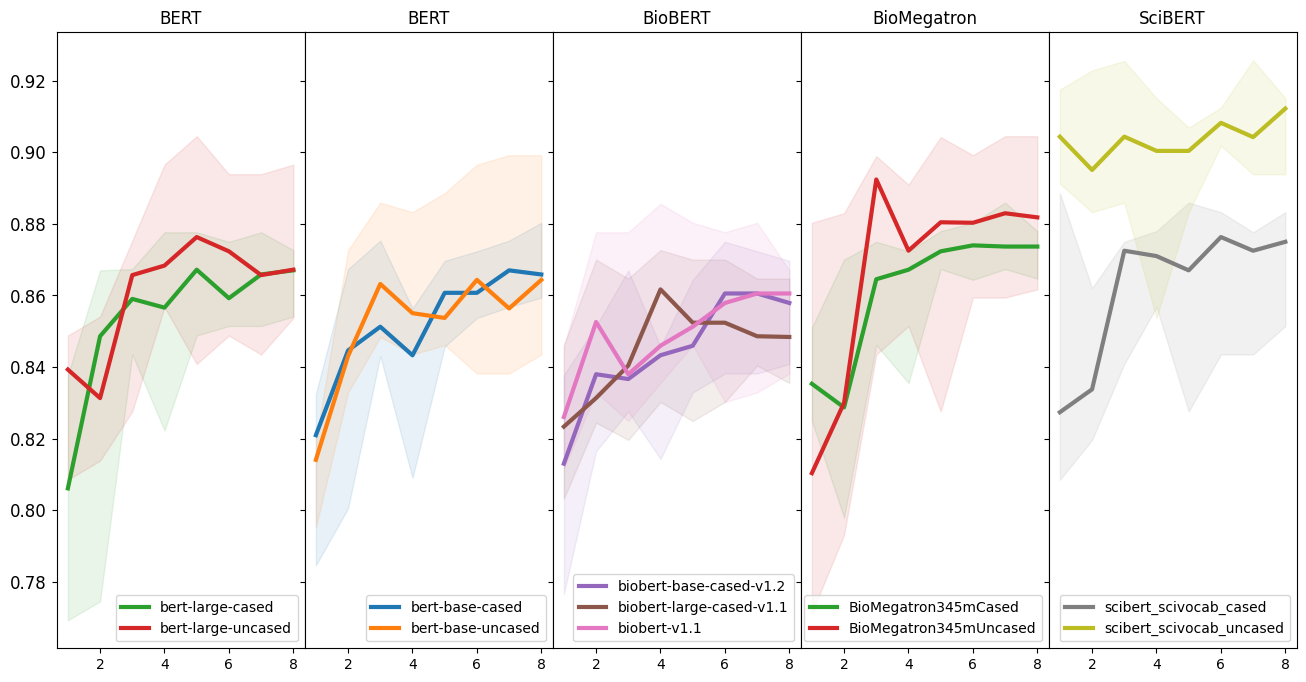

In [12]:
ax = [0, 0, 0, 0, 0]

fig, (ax[0], ax[1], ax[2], ax[3], ax[4]) = pyplot.subplots(1, 5, sharey = True, figsize = (16, 8))

fig.subplots_adjust(wspace = 0, hspace = 0)

# these models have both cased and uncased versions
compare = ['bert-large', 'bert-base', 'dmis-lab/biobert', 'EMBO', 'allenai']

for m, (model, scores) in enumerate(results.items()):
    for c, g in enumerate(compare):
        if model.startswith(g):
            accuraplot(ax[c], llms[m].path.split('/')[-1], scores, palette[m % len(palette)])
            ax[c].set_title(llms[m].name)


pyplot.show()

Surprisingly, base BERT model without domain adaptation successfully learned to classify between generated and real genes name with a decent accuracy. This can be explained either by the fact, that generated names are on a character level statistically different from real ones, despite having the same length distribution, so any neural network can learn to distinguish them; or because BERT also had some biomedical texts in training input.

In general uncased models perform better, and the difference is the most pronounced for SciBERT that became absolute winner. Let's compare uncased SciBERT with remaining models (TinyPubmedBERT and BiomedBERT)

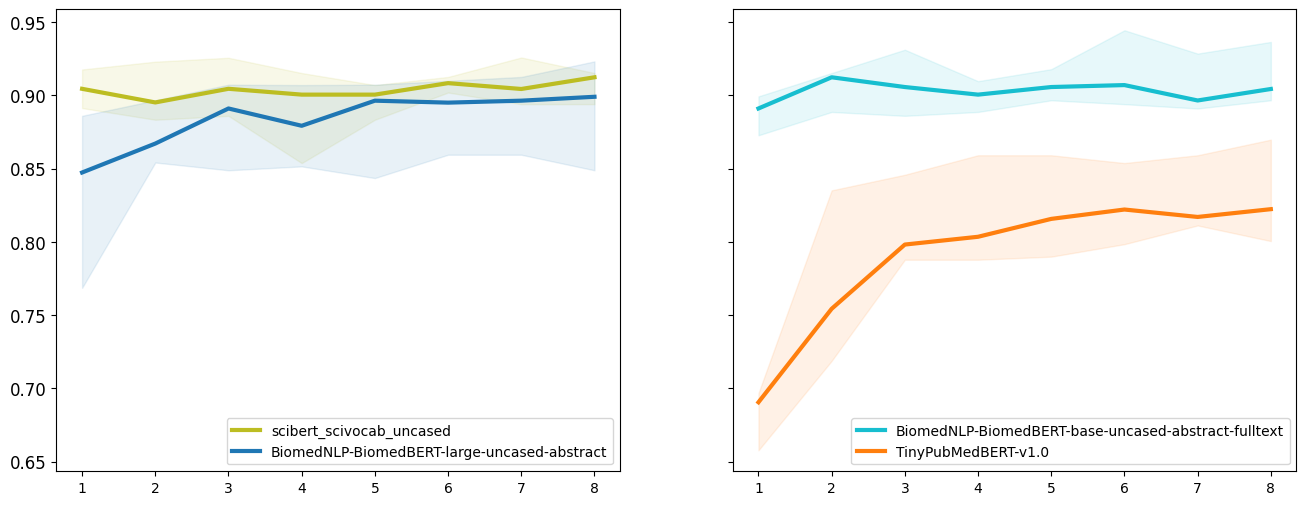

In [13]:
ax = [0, 0]
fig, (ax[0], ax[1]) = pyplot.subplots(1, 2, sharey = True, figsize = (16, 6))

groups = [['BiomedBERT-large', 'scibert_scivocab_uncased'],
          ['BiomedBERT-base', 'TinyPubMedBERT']]

for m, (model, scores) in enumerate(results.items()):
    for c, g in enumerate(groups):
        for i in g:
            if i in model:
                accuraplot(ax[c], llms[m].path.split('/')[-1], scores, palette[m % len(palette)])


pyplot.show()

Interestingly, BiomedBERT model with smaller number of parameters, trained on full texts, performed slightly better than larger model trained on abstracts only. The lower performance of TinyPubMedBERT can be attributed to the fact, that the model has much less parameters (about 14.5m compared to > 100m in other BERT models) and therefore is unable to capture much knowledge.


**LLaMA and GPT models**

LLaMA is a newer and more advanced transformer language model ranging from 7B to 65B parameters that employs decoder-only architecture (unlike BERT which is an encoder-only). Even though its primary application domain is text generation, LLaMA can also be used for classification of text seuqences.

Because LLaMA is significantly larger than language models explored above, we'll need to use quantization and parmeter-efficient fine-tuning method LoRA to be able to train the model in a reasonable amount of time:

In [14]:
class LLaMA(Model):

    def get(self):

        # load model with lower precision to reduce
        # memory and computational costs
        
        quantization_config = BitsAndBytesConfig(
            load_in_4bit = True, 
            bnb_4bit_quant_type = 'nf4',
            bnb_4bit_use_double_quant = True, 
            bnb_4bit_compute_dtype = torch.bfloat16 
        )

        # configure PEFT for faster training
        
        lora_config = LoraConfig(
            r = 16, 
            lora_alpha = 8,
            target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
            lora_dropout = 0.05, 
            bias = 'none',
            task_type = 'SEQ_CLS'
        )
    
        self.tokenizer = AutoTokenizer.from_pretrained(self.path, add_prefix_space = True)
        
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
        self.tokenizer.pad_token    = self.tokenizer.eos_token
    
        self.classifier = AutoModelForSequenceClassification.from_pretrained(
            self.path,
            quantization_config = quantization_config,
            num_labels = 2,
            device_map = 'auto'
        )
        
        self.classifier = prepare_model_for_kbit_training(self.classifier)
        self.classifier = get_peft_model(self.classifier, lora_config)
        
        self.classifier.config.use_cache      = False
        self.classifier.config.pretraining_tp = 1
        self.classifier.config.pad_token_id   = self.tokenizer.pad_token_id

        return self

    
    def tokens(self, data):

        tokens = data.map(lambda sample: self.tokenizer(sample["text"]), batched = True)
        tokens.set_format("torch")
        
        return tokens


I will train and compare two biomedical LLaMA models (trained specifically on PubMed text dataset) with a base LLaMA 3 model:

In [15]:
print("Training LLaMA models to differentiate between gene names and randomly generated sequences...\n")

llamas = [LLaMA('LLaMA',     'meta-llama/Meta-Llama-3-8B'), # LLaMA 3 base model (HuggingFace login required)
          LLaMA('MedLLaMA',  'Henrychur/MMed-Llama-3-8B'),  # biomedical model based on LLaMA 3
          LLaMA('PMC-LLaMA', 'axiong/PMC_LLaMA_13B')]       # biomedical model based on LLaMA 2

trainmodels(llamas, data_gcr, results)

Training LLaMA models to differentiate between gene names and randomly generated sequences...



  0%|          | 0/3 [00:00<?, ?it/s]

The last model to be included in the evaluation is BioGPT, a specialized model based on GPT-2 pre-trained on biomedical research publications:

In [16]:
class BioGPT(Model):

    def __init__(self, path):
        
        self.name = "BioGPT"
        self.path = path
    
    def get(self):
    
        self.tokenizer = BioGptTokenizer.from_pretrained(self.path)
        self.classifier = BioGptForSequenceClassification.from_pretrained(self.path)

        return self


    def tokens(self, data):

        tokens = data.map(lambda i: self.tokenizer(i["text"],
                                    return_tensors = "pt",
                                            padding = True),
                                            batched = True)
        
        return tokens
    

This model has basic and large versions. Let's evaluate both of them:

In [17]:
print("Training BioGPT to differentiate between gene names and randomly generated sequences...\n")

biogpt = [BioGPT('microsoft/BioGPT-Large'),
          BioGPT('microsoft/biogpt')]

trainmodels(biogpt, data_gcr, results)

Training BioGPT to differentiate between gene names and randomly generated sequences...



  0%|          | 0/2 [00:00<?, ?it/s]

Now we can plot and compare results of LLaMA and GPT models:

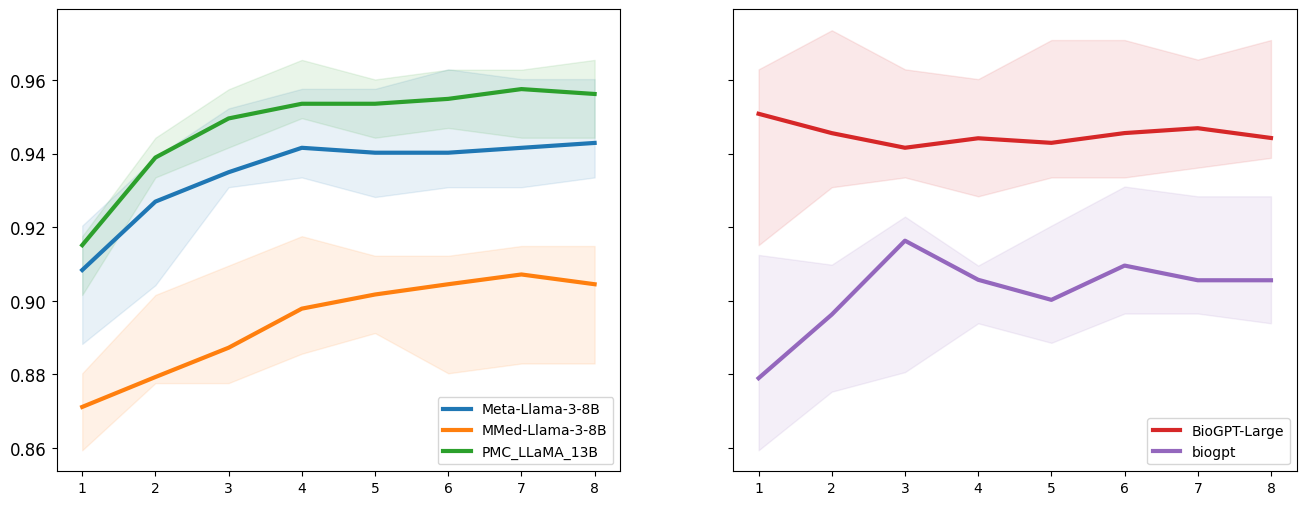

In [18]:
ax = [0, 0] # create two separate subplots for LLaMA and BioGPT
fig, (ax[0], ax[1]) = pyplot.subplots(1, 2, sharey = True, figsize = (16, 6))

for m, model in enumerate(llamas + biogpt):
    accuraplot(ax[0 if m < 3 else 1], model.path.split('/')[-1], results[model.path], palette[m % len(palette)])

pyplot.show()

LLaMA models performed a little better than BERT-based. Surprisingly, specialized model performed worse than base model. This can be explained by the fact, that base model is more advanced version (LLaMA 3) while PMC-LLaMA is using older version (LLaMA 2) as foundation model.

Based on results above, four models can be selected for training on main tasks (driver vs. non-driver gene classification):

In [19]:
top = ['PMC_LLaMA_13B',
       'BioGPT-Large',
       'BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext',
       'scibert_scivocab_uncased']

select = []
for m in llms + llamas + biogpt:
    for t in top:
        if t in m.path: select.append(m)

Let's plot performance of these models all together, and also include training time -- some models might be efficient, while requiring a lot of time and resources to train. The second plot will show how long each model took to reach highest accuracy:

In [20]:
# function to plot accuracy and training time side-by-side
def accutime(select, results, palette):
    
    pyplot.rc('ytick', labelsize = 14)
    pyplot.rc('xtick', labelsize = 14)
    
    ax = [0, 0]
    
    fig, (ax[0], ax[1]) = pyplot.subplots(1, 2, figsize = (18, 6))
    
    for i, m in enumerate(select):
        accuraplot(ax[0], m.name, results[m.path], palette[i % len(palette)])
    
    avetime = {} # avg. training time for each model
    
    # calculate training time for selected models
    for m in select:
        # select index of epoch with max. accuracy and multiply by time for every fold
        times = [numpy.argmax(results[m.path][i]['accuracy']) * results[m.path][i]['train_runtime'] for i in range(0,4)]
        avetime[m.name] = float(sum(times) / 32) # average over folds and epochs
    
    ax[1].grid(axis = 'y', color = 'lightgray', linestyle = 'dashed', zorder = 0)
    ax[1].bar(avetime.keys(), avetime.values(), color = palette, zorder = 3)
    
    # display model name on top of each bar (height equal to time in sec.)
    for bar, label in zip(ax[1].patches, avetime.keys()):
        ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    label,
                    ha = "center",
                    va = "bottom",
                    bbox = dict(boxstyle = "round", fc = 'w', ec = 'lightgray'),
                    fontsize = 12)
    
    # display time in minutes instead of seconds
    ax[1].set_yticks([60, 120, 180, 300], ['1 min.', '2 min.', '3 min.', '5 min.'], fontsize = 12)
    ax[1].set_xticks([])
    
    pyplot.show()

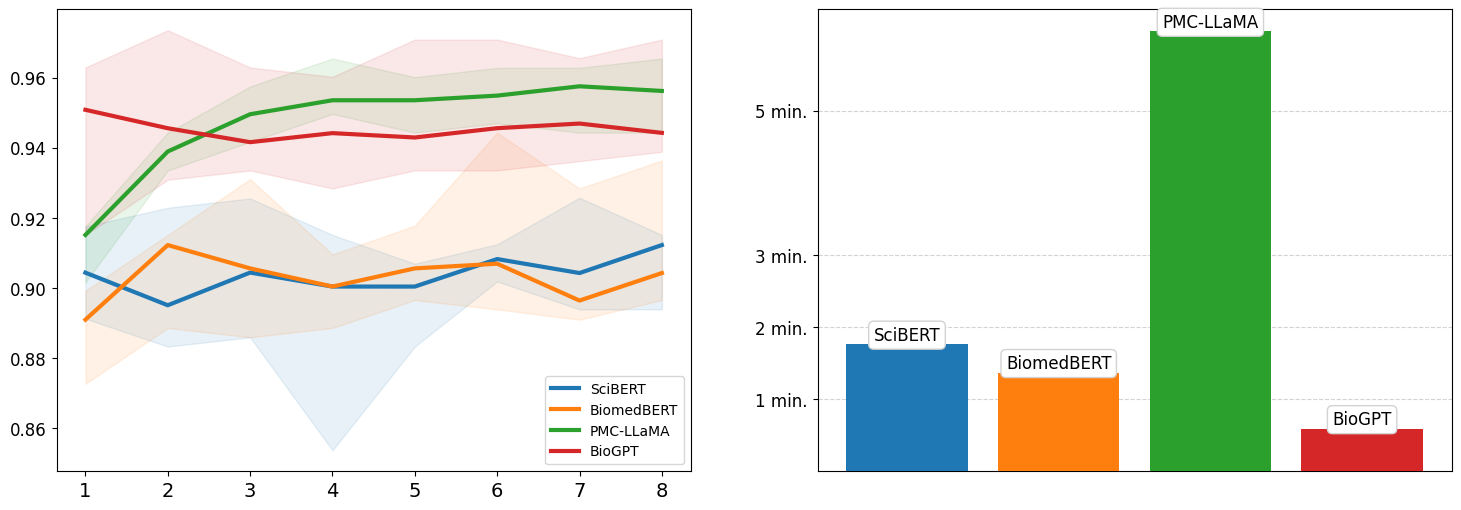

In [21]:
# plot accuracy and training time for selected models
accutime(select, results, palette)

As can be seen from these figures, GPT and LLaMA models show consistently better performance on this task, with the top result achieved by a specialized LLaMA 2 model. However, BioGPT provides almost the same results, while being much smaller and therefore requiring much lesser time for training.

**Cancer driver vs. non-driver gene classification**

After doing initial performance testing, we can turn to the real task of identification of cancer driver genes using models that were selected based on previous analysis:

In [25]:
# load the dataset containing known cancer-driver genes
# labeled as 1 and non-driver genes labele with 0

data_gco = traindata('dataset/genes_cancer_other.csv')

performance = loadresults('model_classification')

print("Training models to identify cancer driver genes...\n")

trainmodels(select, data_gco, performance, 'model_classification')

Training models to identify cancer driver genes...



  0%|          | 0/4 [00:00<?, ?it/s]

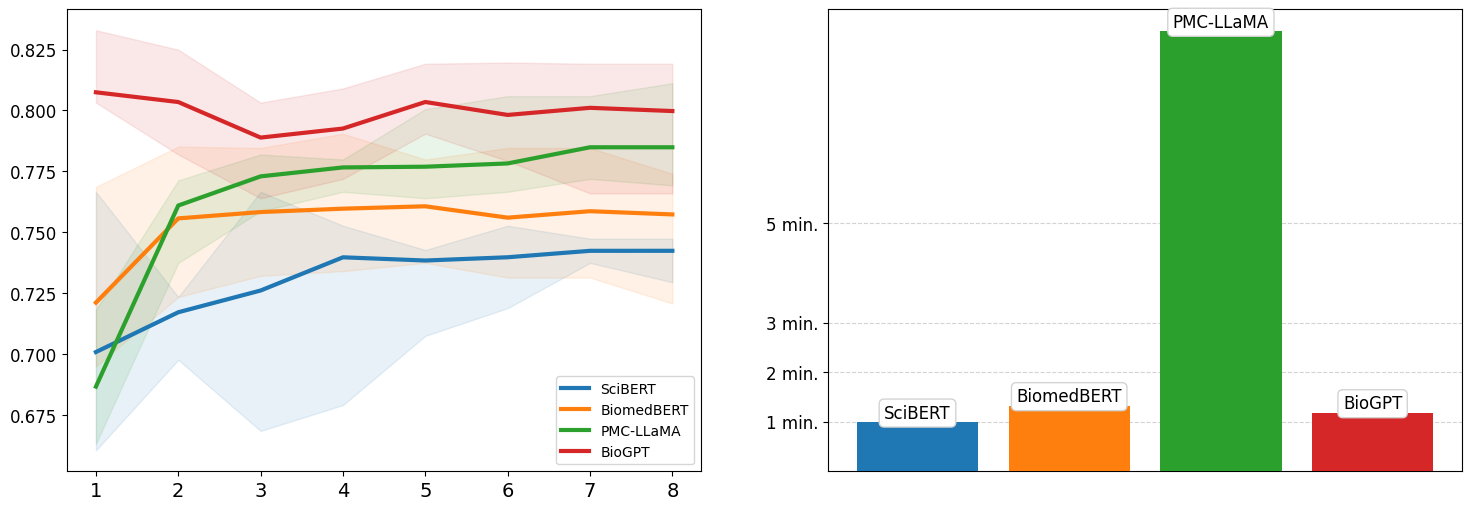

In [26]:
# plot accuracies and training time for driver gene classigication
accutime(select, performance, palette)

On this task, BioGPT emerged as absolute winner.

**Clustering of cancer driver vs. non-driver genes**

In this section I will extract embeddgins of different genes from trained BioGPT and visualize their distribution on TSNE plot:

In [32]:
model = BioGPT('microsoft/BioGPT-Large').get()

train(model, data_gco[1], 1, nodebug = False) ;

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.537200,0.401913,0.832891,0.832891


In [33]:
# collect input data for the model
genepool = pandas.read_csv('dataset/genes_cancer_other.csv', skiprows = 1, names = ['gene', 'label'])

In [34]:
# run inference and get text embedding from the last layer
def embedding(model, text):
    model.classifier.cuda()
    
    inputs = model.tokenizer(text, return_tensors = "pt").to('cuda')
    outputs = model.classifier(**inputs, output_hidden_states = True)
    
    hidden = outputs.hidden_states[-1][0].detach().cpu().numpy()
    return hidden[-1]

# run model on a dataset, extract embeddings and convert them to 2D using TSNE
def clusterpoints(model, data, rand = 101101011):
    embeddings = data.progress_apply(lambda i: embedding(model, i))
    embeddings = numpy.stack(embeddings.values)
    tsne = TSNE(n_components = 2, random_state = rand).fit_transform(embeddings)
    return tsne

Calculate TSNE projection of embeddings from trained and non-trained BioGPT models:

In [35]:
model_initial = BioGPT('microsoft/BioGPT-Large').get()

points = [clusterpoints(m, genepool["gene"]) for m in [model_initial, model]]

  0%|          | 0/1506 [00:00<?, ?it/s]

  0%|          | 0/1506 [00:00<?, ?it/s]

The following function will draw a subset of samples on a canvas using 2D coordinates for every sample obtained by TSNE:

In [43]:
def genemap(canvas, tsne, data, k = 256 + 256):

    # select a subset of genes to be displayed
    samples = random.sample(range(0, len(tsne)), k = k)

    canvas.axis('off')
    
    # initialize the plot by drawing a single dot for each sample
    scatter = canvas.scatter(tsne[:,0], tsne[:,1], c = 'w')

    # draw text label for each sample
    for s in samples:
    
        x, y   = tsne[s]
        entity = data['gene'][s]
        label  = data['label'][s]

        # set colors for driver and non-driver genes
        if label == 0:
            lc = 'gray'
            ec = 'gray'
            fc = 'w'
        else:
            fc = 'black'
            ec = 'w'
            lc = 'w'
        
        canvas.text(x, y, entity,
                          fontsize   = 18,
                          fontweight = 'normal' if label == 0 else 'bold',
                          color = lc,
                          bbox = dict(boxstyle = "round",
                                            fc = fc,
                                            ec = ec))


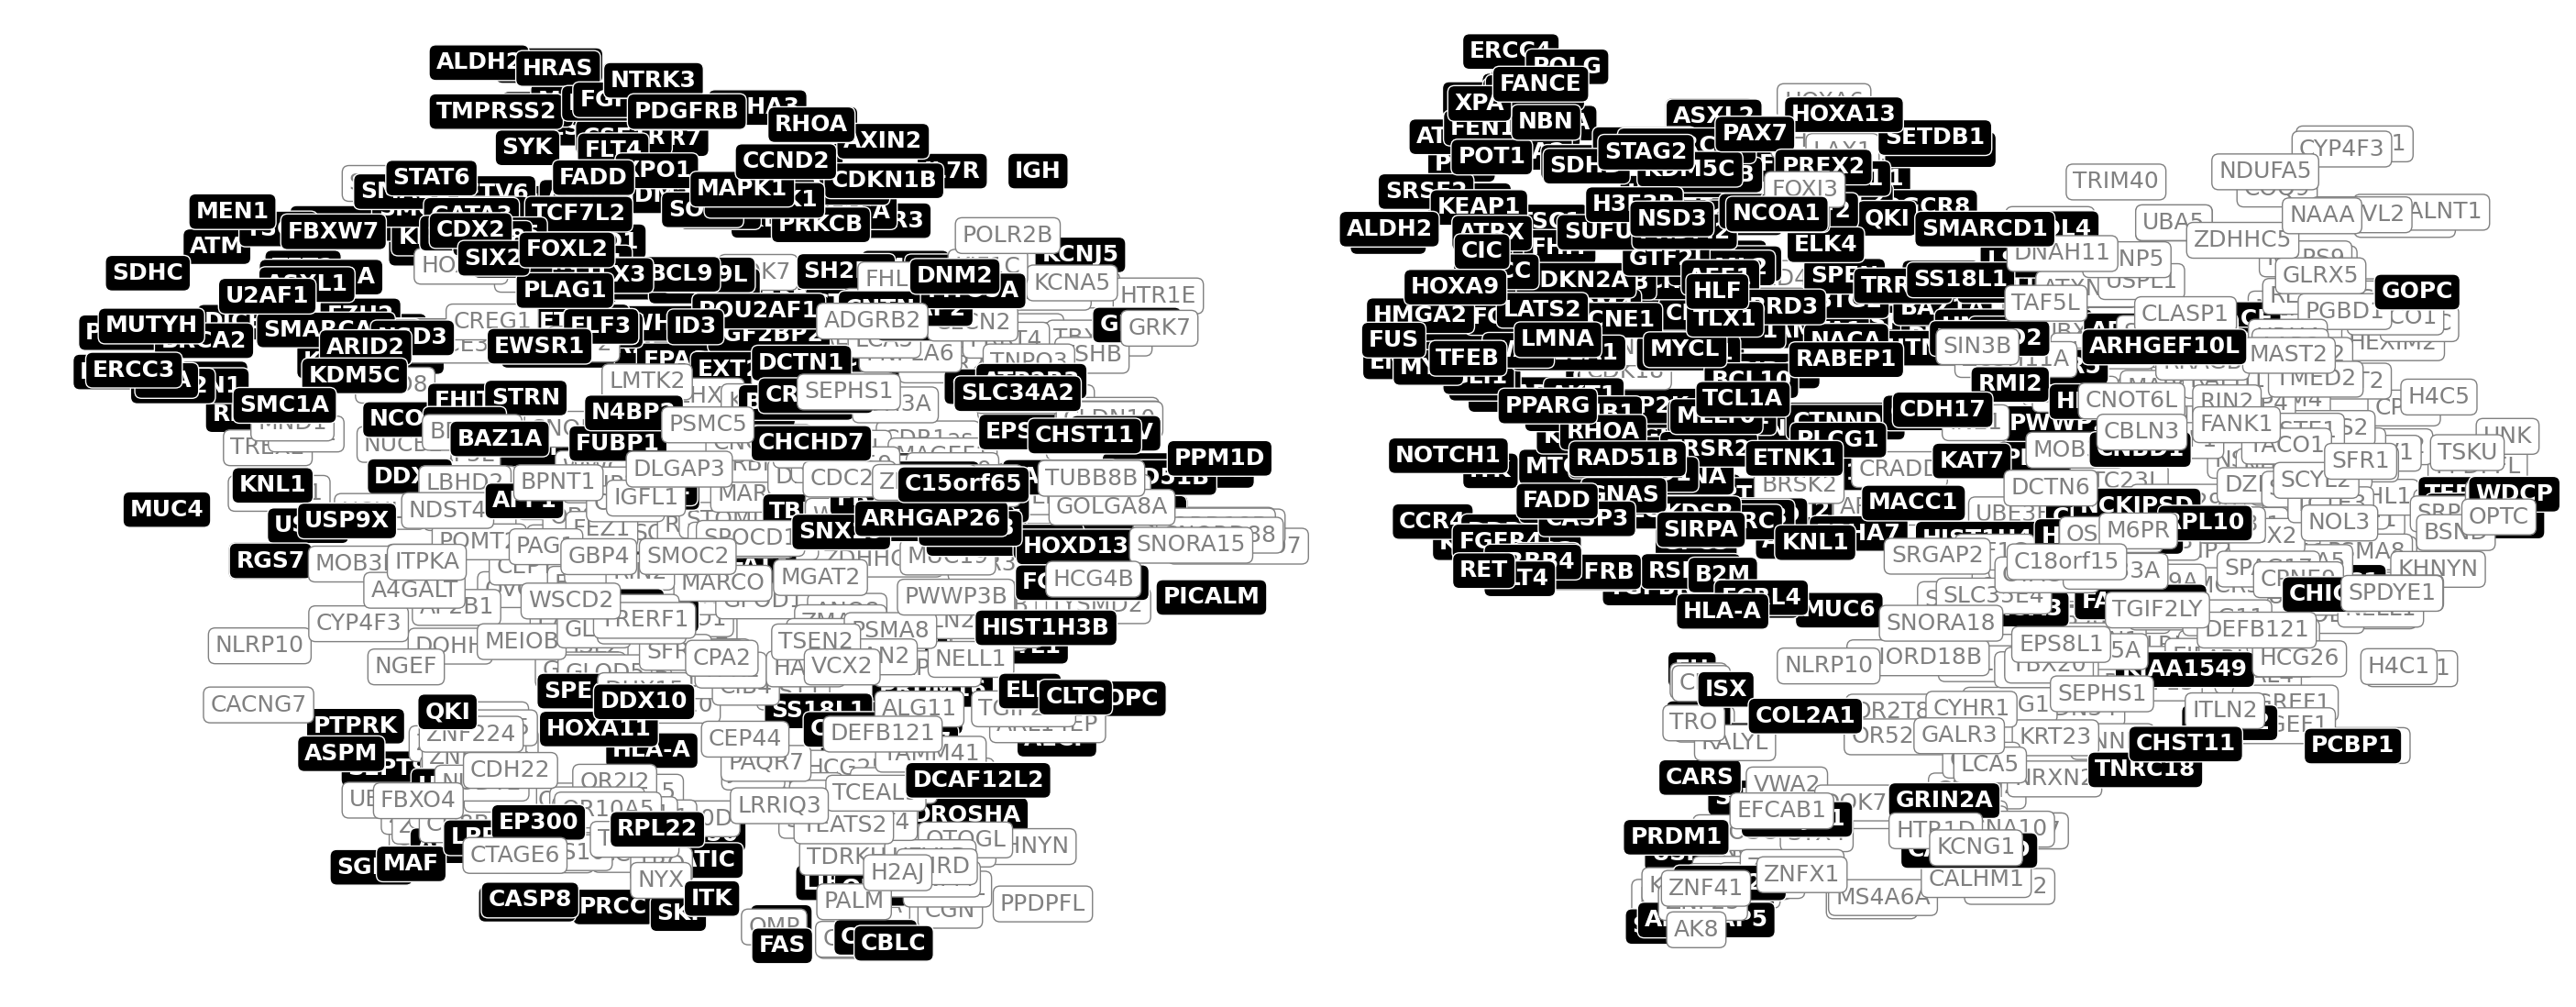

In [44]:
fig, (ax_initial, ax_trained) = pyplot.subplots(1, 2, figsize = (36, 14))
fig.subplots_adjust(wspace = 0, hspace = 0)

genemap(ax_initial, points[0], genepool)
genemap(ax_trained, points[1], genepool)

pyplot.show()

### Task 2. Treatment outcome prediction

Drug response prediction is important for developing personalized treatments for cancer, because tumours associated with specific mutations will respond only to specific treatments while remaining resistant to other. Systems based on deep learning for predicting drug responses have been developed [10,11]. These systems rely on features such as gene expression profile or molecular structure. In this section it will be investigated if biomedical language models can also be used to predict treatment outcome for specific drug and genetic profile in cancer. That opens potential for the range of applications, including automatic generation of personalized treatment plans.

#### Dataset

CIViC (Clinical Interpretation of Variants in Cancer) is a curated knowledge base of associations between genetic mutations, drugs and treatment outcomes in different types of cancer, assembled from literature [12]. The dataset is available as TSV file:

In [40]:
evidence = pandas.read_csv('dataset/nightly-ClinicalEvidenceSummaries.tsv', sep = '\t')

# select only those records relevant to therapy outcome
therapies = ['molecular_profile', 'disease', 'therapies', 'significance', 'evidence_direction']
evidence  = evidence[~evidence.therapies.isna()][therapies]
evidence

,molecular_profile,disease,therapies,significance,evidence_direction
9,DNMT3A R882,Acute Myeloid Leukemia,Daunorubicin,Resistance,Does Not Support
10,MAP2K1 P124S,Melanoma,Selumetinib,Resistance,Supports
11,MAP2K1 Q56P,Melanoma,Selumetinib,Resistance,Supports
12,NRAS Q61,Melanoma,Vemurafenib,Resistance,Supports
13,PDGFRA D842V,Gastrointestinal Stromal Tumor,Imatinib,Resistance,Supports
...,...,...,...,...,...
4428,IFNGR1 Loss,Melanoma,Ipilimumab,Resistance,Supports
4429,TOP1 Amplification,Colorectal Cancer,"Cetuximab,FOLFIRI Regimen",Sensitivity/Response,Supports
4433,EGFR L858R OR EGFR Exon 19 Deletion,Lung Non-small Cell Carcinoma,"Pemetrexed,Amivantamab,Carboplatin",Sensitivity/Response,Supports
4434,RET Mutation,Medullary Thyroid Carcinoma,Selpercatinib,Sensitivity/Response,Supports


In the table above, *molecular profile* has gene name (e.g. DNMT3A or NRAS) and corresponding mutation specified. The response to the treatment can be one of the following: 

In [45]:
evidence.significance.value_counts()

significance
Sensitivity/Response    1644
Resistance              1009
Reduced Sensitivity       15
Adverse Response           9
Name: count, dtype: int64

To get a quick preview of the data, let's plot number of resistance or sensitivity reaction for the top 12 most frequent drugs in the dataset:

In [48]:
therapies = list(evidence.therapies.value_counts().to_dict().keys())
print(f'Total number of different therapies: {len(therapies)}, dataset size: {len(evidence)}')

Total number of different therapies: 675, dataset size: 2677


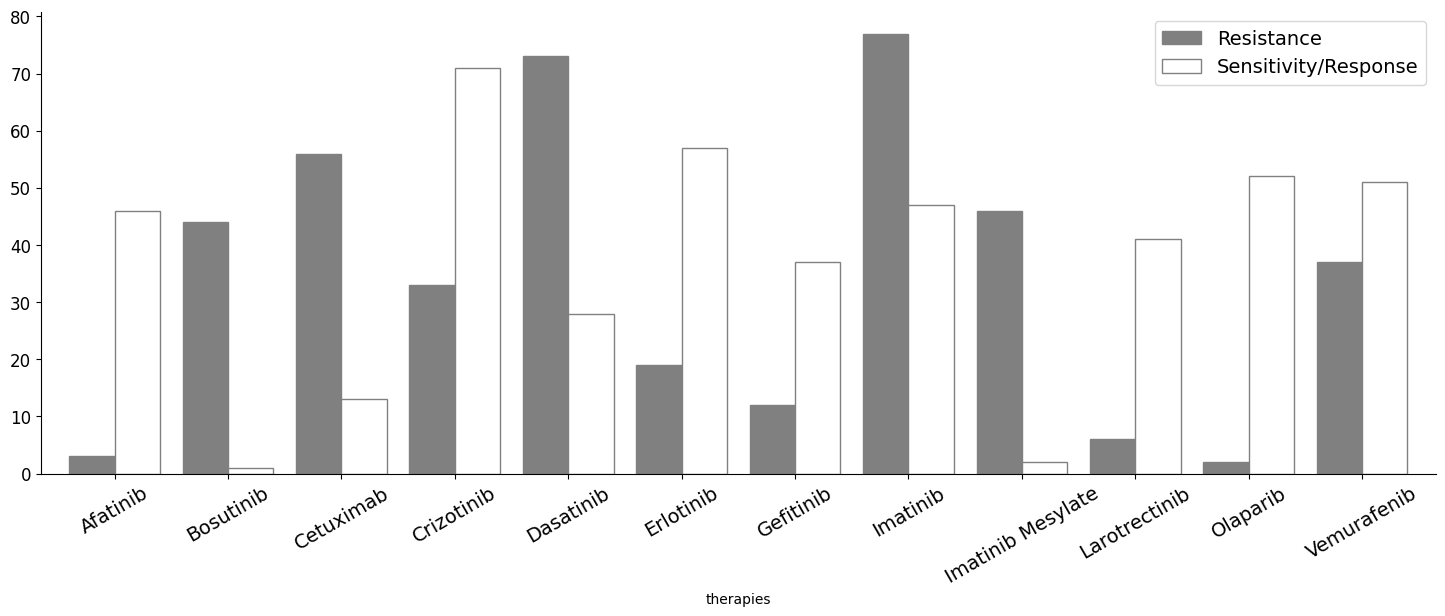

In [46]:
# select 12 most frequent therapies
therapies = therapies[0:12]
responses = ['Resistance', 'Sensitivity/Response']
# preview only resistance or response to selected therapies
subset = evidence[evidence.therapies.isin(therapies) &
                  evidence.significance.isin(responses)]

# calculate number of each reaction type for every drug
regroups = subset.pivot_table(index = 'therapies', columns = 'significance', aggfunc = 'size')

# plot the bar chart and apply formatting
ax = regroups.plot(kind = 'bar', figsize = (18, 6), width = 0.8, rot = 30, color =['gray', 'white'], edgecolor = 'gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize = 14)
ax.tick_params(axis = "y", labelsize = 12)
ax.tick_params(axis = "x", labelsize = 14)

The dataset is highly imbalanced, as evident from the bar chart above. That imbalance will make straightforward attemps at classification futile: at best classifier is going to learn statistical irregularities in the input data, e.g. by answering *resistance* for all cases of Afatinib.

#### Question Answering

BioGPT was deliberately fine-tune to answer biomedical questions on datasets such as PubMedQA, therefore it might be interesting to check if BioGPT can answer questions about resistance or response of different genetic mutations to specific therapy, especially given the fact that this knowledge was manually collected from literature.

To do this, first I will collect information from the table into a dictionary that will for every triplet (disease, mutation, therapy) keep a value of 0 in case disease will be resistant to treatment, 1 otherwise and 2 if evidence is contradictory:

In [50]:
responses = {} # store information about threatment outcomes

# function to add value from table row to dictionary
def collect(row, responses):
    mutations = row['molecular_profile']
    disease = row['disease']
    drugs = row['therapies'].split(',')
    drugs = drugs[0] if len(drugs) == 1 else ', '.join(drugs[:-1]) + ' and ' + drugs[-1]
    s = (disease, mutations, drugs)
    label = 1 if 'Sensitivity' in row['significance'] else 0
    if row['evidence_direction'] != 'Supports':
        label = (label + 1) % 2
    if s not in responses:
        responses[s] = set()
    responses[s].add(label)

# scan everty row of the table and collect data
evidence.apply(lambda record: collect(record, responses), axis = 1)

for statement, label in responses.items():
    responses[statement] = label.pop() if len(label) == 1 else 2 ;

Now I will crete a question from each each triplet using a standard template for BioGPT model, and record the answer: yes, no or maybe. I will process the whole dictionary in batches of 48 questions and calculate percentage of the correct answwers after every batch, as well as the total number of different answers given by language model:

In [58]:
biogpt_qa = BioGptForCausalLM.from_pretrained("microsoft/BioGPT-Large-PubMedQA")
tokenizer = BioGptTokenizer.from_pretrained("microsoft/BioGPT-Large-PubMedQA")

generator = pipeline('text-generation', model = biogpt_qa, tokenizer = tokenizer)
set_seed(42)

In [104]:
questions = []
answers = {}

right = 0
wrong = 0

acounts = {'yes': 0, 'no' : 0, 'maybe' : 0}

for i, ((disease, mutation, drugs), correct) in enumerate(tqdm(responses.items())):

    q = f""" question: Will patient respond to to therapy with {drugs}?
                     (a) Yes, patient will respond to treatment.
                     (b) No, the tumour will be resistant to treatment.
             context: Patient was diagnosed with {disease} and has {mutation} genetic mutation.
             answer: the answer to the question given the context is """

    questions.append(q)

    if len(questions) == 48 or (i + 1)  == len(responses):
        reply = generator(questions, max_length = 128, num_return_sequences = 1, do_sample = True)
        for r in reply:

            try:
                
                yn = re.findall('the answer to the question given the context is  ([a-zA-Z"]+).', r[0]['generated_text'])
                yn = yn[0].strip('"').lower()
                
                answers[(disease, mutation, drugs)] = yn

                if ['no', 'yes', 'maybe'][correct] == yn:
                    right += 1
                else:
                    wrong += 1

                acounts[yn] += 1

            except:
                pass
            
        questions = []

        at = sum(acounts.values())
        aperc = {a: round(ac*100/at) for a, ac in acounts.items()}
        
        print(f'correct answers: {round(right * 100/(right + wrong), 2)}%, answers: {acounts}')

  0%|          | 0/1168 [00:00<?, ?it/s]

correct answers: 97.92%, answers: {'yes': 47, 'no': 0, 'maybe': 1}
correct answers: 51.04%, answers: {'yes': 92, 'no': 1, 'maybe': 3}
correct answers: 67.36%, answers: {'yes': 140, 'no': 1, 'maybe': 3}
correct answers: 50.79%, answers: {'yes': 185, 'no': 1, 'maybe': 5}
correct answers: 59.41%, answers: {'yes': 230, 'no': 2, 'maybe': 7}
correct answers: 65.51%, answers: {'yes': 276, 'no': 3, 'maybe': 8}
correct answers: 69.25%, answers: {'yes': 320, 'no': 6, 'maybe': 9}
correct answers: 71.8%, answers: {'yes': 363, 'no': 9, 'maybe': 11}
correct answers: 73.78%, answers: {'yes': 406, 'no': 10, 'maybe': 15}
correct answers: 75.57%, answers: {'yes': 450, 'no': 11, 'maybe': 18}
correct answers: 77.61%, answers: {'yes': 497, 'no': 12, 'maybe': 18}
correct answers: 78.78%, answers: {'yes': 541, 'no': 13, 'maybe': 21}
correct answers: 79.61%, answers: {'yes': 584, 'no': 14, 'maybe': 25}
correct answers: 80.63%, answers: {'yes': 629, 'no': 14, 'maybe': 28}
correct answers: 81.36%, answers: {'ye

Even though the overall accuracy was high after some batches, it is evident that BioGPT model simply outputted *yes* answer most of the times (i.e. that therapy will be helpful) and because the dataset was imbalanced, that simple strategy yielded high accuracy scores.

### Conclusion

Even though LLMs are not yet precise or accurate enough to enable, for example, automated medicine recommendations in complex cases, biomedical language models can find applications in research, such as generating new hypotheses to be tested (i.e. suggest genes that might be potential targets for new therapies).

### References

    [1] S. Spangler et al., “Automated hypothesis generation based on mining scientific literature,” in Proceedings of the 20th ACM SIGKDD international conference on Knowledge discovery and data mining, New York New York USA: ACM, Aug. 2014, pp. 1877–1886. doi: 10.1145/2623330.2623667.
    
    [2] M. Nourbakhsh, K. Degn, A. Saksager, M. Tiberti, and E. Papaleo, “Prediction of cancer driver genes and mutations: the potential of integrative computational frameworks,” Briefings in Bioinformatics, vol. 25, no. 2, p. bbad519, Jan. 2024, doi: 10.1093/bib/bbad519.
    
    [3] M. R. Waarts, A. J. Stonestrom, Y. C. Park, and R. L. Levine, “Targeting mutations in cancer,” Journal of Clinical Investigation, vol. 132, no. 8, p. e154943, Apr. 2022, doi: 10.1172/JCI154943
    
    [4] P. A. Futreal et al., “A census of human cancer genes,” Nat Rev Cancer, vol. 4, no. 3, pp. 177–183, Mar. 2004, doi: 10.1038/nrc1299.
    
    [5] D. Ostroverkhova, T. M. Przytycka, and A. R. Panchenko, “Cancer driver mutations: predictions and reality,” Trends in Molecular Medicine, vol. 29, no. 7, pp. 554–566, Jul. 2023, doi: 10.1016/j.molmed.2023.03.007.
    
    [6] Z. Sondka, S. Bamford, C. G. Cole, S. A. Ward, I. Dunham, and S. A. Forbes, “The COSMIC Cancer Gene Census: describing genetic dysfunction across all human cancers,” Nat Rev Cancer, vol. 18, no. 11, pp. 696–705, Nov. 2018, doi: 10.1038/s41568-018-0060-1.
    
    [7] A. Colaprico et al., “Interpreting pathways to discover cancer driver genes with Moonlight,” Nat Commun, vol. 11, no. 1, p. 69, Jan. 2020, doi: 10.1038/s41467-019-13803-0.
    
    [8] V. Tshitoyan et al., “Unsupervised word embeddings capture latent knowledge from materials science literature,” Nature, vol. 571, no. 7763, pp. 95–98, Jul. 2019, doi: 10.1038/s41586-019-1335-8.
    
    [9] D. Grissa, A. Junge, T. I. Oprea, and L. J. Jensen, “Diseases 2.0: a weekly updated database of disease–gene associations from text mining and data integration,” Database, vol. 2022, p. baac019, Mar. 2022, doi: 10.1093/database/baac019.
    
    [10] S. Chawla et al., “Gene expression based inference of cancer drug sensitivity,” Nat Commun, vol. 13, no. 1, p. 5680, Sep. 2022, doi: 10.1038/s41467-022-33291-z.
    
    [11] P. Li, Z. Jiang, T. Liu, X. Liu, H. Qiao, and X. Yao, “Improving drug response prediction via integrating gene relationships with deep learning,” Briefings in Bioinformatics, vol. 25, no. 3, p. bbae153, Mar. 2024, doi: 10.1093/bib/bbae153.
    
    [12] M. Griffith et al., “CIViC is a community knowledgebase for expert crowdsourcing the clinical interpretation of variants in cancer,” Nat Genet, vol. 49, no. 2, pp. 170–174, Feb. 2017, doi: 10.1038/ng.3774.

### Appendix

Supplementary tables with model information and performance scores:

In [52]:
params = {} # get N of parameters for each model
for m in tqdm(llms + llamas + biogpt):
    params[m.path] = sum(p.numel() for p in m.get().classifier.parameters())
    if 'llama' in m.path.lower():
        params[m.path] *= 2

In [ ]:
# convert parameter number and training time to human-readable string
def parhum(n): return f'{round(n / 1000000,1)}M' else f'{round(n / 1000000000, 1)}B'
def timhum(s): return f'{round(s)} sec' if s < 60 else f'{round(s / 60)} min'

# display table with results of all models sorted by avg. max. accuracy
def accutable(results, labels):
    table = []
    
    for i, (p, folds) in enumerate(results.items()):
    
        amax = [round(max(folds[i]['accuracy']), 2) for i in range(0,4)]
        amti = [(numpy.argmax(folds[i]['accuracy']) + 1) * folds[i]['train_runtime'] for i in range(0,4)]
        
        record = {'model' : labels[i],
                  'params' : parhum(params[p]),
                  'time' : timhum(float(sum(amti)/32)),
                  'acc\nmed' : round(numpy.median(amax), 2),
                  'acc\nstd' : round(numpy.std(amax), 2),
                  'acc\nmin' : min(amax),
                  'acc\nmax' : max(amax),
                 }
    
        table.append(record)
    
    table = pandas.DataFrame(table).sort_values(by = ['acc\nmed', 'time'], ascending = [False, True])
    table = table.reset_index(drop = True)
    table.index += 1
    
    print(tabulate(table, headers = 'keys', tablefmt = 'psql'))

In [43]:
# display results table for gene vs. random sequence classification task

accutable(results,
          labels = ['BERT cased',
                   'BERT uncased',
                   'BERT-large cased',
                   'BERT-large uncased',
                   'BioBERT cased',
                   'BioBERT uncased',
                   'BioBERT-large cased',
                   'SciBERT cased',
                   'SciBERT uncased',
                   'BiomedBERT fulltext',
                   'BiomedBERT abstract',
                   'TinyPubMedBERT',
                   'BioMegatron cased',
                   'BioMegatron uncased',
                   'LLaMA 3 8B',
                   'MMed-LLaMA 3 8B',
                   'PMC-LLaMA 2 13B',
                   'BioGPT-large',
                   'BioGPT',
                 ])

+----+---------------------+----------+--------+-------+-------+-------+-------+
|    | model               | params   | time   |   acc |   acc |   acc |   acc |
|    |                     |          |        |   med |   std |   min |   max |
|----+---------------------+----------+--------+-------+-------+-------+-------|
|  1 | PMC-LLaMA 2 13B     | 13.1B    | 7 min  |  0.96 |  0.01 |  0.95 |  0.97 |
|  2 | BioGPT-large        | 1.6B     | 1 min  |  0.95 |  0.01 |  0.95 |  0.97 |
|  3 | LLaMA 3 8B          | 8.1B     | 4 min  |  0.94 |  0.01 |  0.93 |  0.96 |
|  4 | SciBERT uncased     | 109.9M   | 2 min  |  0.92 |  0.01 |  0.9  |  0.93 |
|  5 | BioGPT              | 346.8M   | 48 sec |  0.92 |  0.01 |  0.9  |  0.93 |
|  6 | BiomedBERT fulltext | 109.5M   | 2 min  |  0.91 |  0.01 |  0.9  |  0.94 |
|  7 | MMed-LLaMA 3 8B     | 8.1B     | 4 min  |  0.9  |  0.01 |  0.9  |  0.92 |
|  8 | BiomedBERT abstract | 335.1M   | 7 min  |  0.9  |  0.02 |  0.86 |  0.92 |
|  9 | BioMegatron uncased |

In [45]:
# display results table for driver vs. non-driver gene classification task

accutable(performance,
          [
          'SciBERT uncased',
          'BiomedBERT fulltext',
          'PMC-LLaMA 2 13B',
          'BioGPT-large'
         ])

+----+---------------------+----------+--------+-------+-------+-------+-------+
|    | model               | params   | time   |   acc |   acc |   acc |   acc |
|    |                     |          |        |   med |   std |   min |   max |
|----+---------------------+----------+--------+-------+-------+-------+-------|
|  1 | BioGPT-large        | 1.6B     | 2 min  |  0.82 |  0.01 |  0.8  |  0.83 |
|  2 | PMC-LLaMA 2 13B     | 13.1B    | 10 min |  0.79 |  0.01 |  0.77 |  0.81 |
|  3 | BiomedBERT fulltext | 109.5M   | 2 min  |  0.76 |  0.02 |  0.74 |  0.79 |
|  4 | SciBERT uncased     | 109.9M   | 1 min  |  0.74 |  0.01 |  0.74 |  0.77 |
+----+---------------------+----------+--------+-------+-------+-------+-------+
